In [444]:
import swat
import getpass
import re
import pandas as pd
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Conexão com servidor

In [445]:
# Conexao com servidor
try:
    conn = swat.CAS( hostname="servidor", port="5570",
                    username="usuario", password="senha",
                    protocol="cas", name="pythonSession")
    conn.loadactionset("sampling")
    conn.loadactionset("decisionTree")
    conn.loadactionset("autotune")

except swat.SWATError as err:
    print(err)

NOTE: Added action set 'sampling'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'autotune'.


# Verifica Tabelas

In [434]:
# Tabelas em memoria
conn.tableinfo(caslib="CASUSER")

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,...,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier,SourceModTimeFormatted,SourceModTime
0,TABELA_DEF,22223,8,0,utf-8,2018-10-24T09:47:33-04:00,2018-10-24T09:47:33-04:00,2018-10-25T17:54:46-04:00,UTF8,1.856008e+09,...,1,0,0,TABELA_DEF.sashdat,CASUSER(sasdemo),0,sasdemo,,2018-10-23T16:12:38-04:00,1.855945e+09
1,HMEQ,5960,13,0,utf-8,2018-10-25T17:47:54-04:00,2018-10-25T17:47:54-04:00,2018-10-25T17:52:57-04:00,UTF8,1.856123e+09,...,1,0,0,HMEQ.sashdat,CASUSER(sasdemo),0,sasdemo,,2018-09-02T21:32:31-04:00,1.851558e+09


# Análise da Tabela

In [435]:
conn.CASTable( name="TABELA_DEF", libname="CASUSER").describe().round(2)

,Cli_Aceitacao,Cli_Idade,Total_Investido,Tempo_Fiel,TARGET
count,21138.00,20715.00,22223.00,21942.00,22223.00
mean,8.71,53.80,4420.59,6.56,0.25
std,3.42,13.21,7559.05,4.66,0.43
min,0.00,18.00,0.01,0.00,0.00
25%,6.00,44.00,0.01,4.00,0.00
50%,8.00,54.00,2000.00,5.00,0.00
75%,11.00,64.00,5999.99,8.00,0.00
max,34.00,79.00,296313.85,39.00,1.00


In [453]:
# 0 = trainamento, 1 = teste
conn.sampling.stratified(
    table={"name":"TABELA_DEF", "groupBy":"TARGET"},
    output={"casOut":{"name":"tabela_part", "replace":1}, "copyVars":"ALL"},
    samppct=70,
    partind=True
)

NOTE: Using SEED=2140533496 for sampling.


[outputSize]

 {'outputNObs': 22223.0, 'outputNVars': 9}

[STRAFreq]

 Frequencies
 
    ByGrpID TARGET   NObs  NSamp
 0        0      0  16718  11703
 1        1      1   5505   3853

[OutputCasTables]

              casLib         Name Label   Rows  Columns  \
 0  CASUSER(sasdemo)  tabela_part        22223        9   
 
                                             casTable  
 0  CASTable('tabela_part', caslib='CASUSER(sasdem...  

+ Elapsed: 0.0299s, user: 0.031s, sys: 0.017s, mem: 17.4mb

# Definição de Variáveis

## Imputação de Valores

In [450]:
# Imputacao de Valores
db_var_imp = conn.datapreprocess.impute(table="tabela_part",
                          methodnominal="mode",  methodinterval ="median",
                          casout={"name":"TAB_FIM_TRATADA","caslib":"CASUSER(sasdemo)", "replace":1},
                           outvarsnameprefix='')

db_tratado = conn.CASTable("TAB_FIM_TRATADA")

,_PartInd_,Cli_Aceitacao,Cli_Idade,TARGET,Tempo_Fiel,Total_Investido,Cli_Regiao,Cli_Status,ID
0,1.0,10.0,76.0,0.0,4.0,16000.00,Nordeste,Ouro,0000000140
1,0.0,4.0,49.0,0.0,5.0,6000.00,Nordeste,Ouro,0000000620
2,0.0,5.0,70.0,1.0,8.0,0.02,Nordeste,Prata,0000000868
3,0.0,10.0,65.0,1.0,7.0,0.01,Nordeste,Bronze,0000001120
4,0.0,11.0,68.0,0.0,8.0,0.01,Nordeste,Bronze,0000002313


In [451]:
# Separacao de Colunas
columns_info = conn.columninfo(table=db_tratado).ColumnInfo

target = "TARGET"
columns_char = list(columns_info["Column"][columns_info["Type"]=="char"].get_values())
columns_char.remove("ID")
columns_double = list( columns_info["Column"][ columns_info["Type"]=="double" ])
columns_double.remove("TARGET")
columns_double.remove("_PartInd_")

print(columns_char)
print(columns_double)

['Cli_Regiao', 'Cli_Status']
['Cli_Aceitacao', 'Cli_Idade', 'Tempo_Fiel', 'Total_Investido']


# Criação do Modelo

## Random Forest

In [454]:
# Treinamento e Scoragem - Random Forest
result = conn.autotune.tuneForest(
    # Treina e salva o codigo de treinamento na tabela rf_train.
    trainOptions={
         "table"   : {"name":"tabela_part", "where": "_PartInd_=0"},
         "inputs"  : columns_double+columns_char,
         "target"  : target,
         "nominals" : columns_char+[target],
         "casout"  : {"name":"rf_train"}
     },
    tunerOptions={
         "maxIters": 5,
         "maxTime": 3600,
         "searchMethod": "GA",
         "objective": "KS",
         "userDefinedPartition": True,
         "targetEvent" : "1"
     },
    # Utiliza o modelo criado e otimizado para scoragem da base particionada
    scoreOptions = {
        "table": { "name":"tabela_part", "where": "_PartInd_=1" },
        "modeltable": {"name":"rf_train"},
        "casout": {"name":"rf_score", "replace":1},
        "copyvars":["ID", "TARGET"]
    }
)

# Scoragem - Random Forest
rf_score = conn.CASTable("rf_score") 
rf_score.head()

NOTE: Autotune is started for 'Forest' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXEVALS=50.
NOTE: Autotune option MAXTIME=3600 (sec.).
NOTE: Autotune option SEED=934762927.
NOTE: Autotune objective is 'Kolmogorov-Smirnov'.
NOTE: Autotune number of parallel evaluations is set to 4, each using 0 worker nodes.
         Iteration       Evals     Best Objective        Time
                 0           1             0.4111        9.02
                 1          10             0.4344       22.15
                 2          19             0.4344       25.45
                 3          28             0.4344       29.08
                 4          37             0.4344       33.71
                 5          46             0.4344       38.49
NOTE: Autotune time is 39.92 seconds.


,ID,TARGET,I_TARGET,_MissIt_,_Vote_,P_TARGET0,P_TARGET1
0,0000000140,0.0,0,0.0,61.0,0.968254,0.031746
1,0000000868,1.0,0,1.0,63.0,1.000000,0.000000
2,0000002313,0.0,0,0.0,54.0,0.857143,0.142857
3,0000002771,0.0,0,0.0,62.0,0.984127,0.015873
4,0000003131,0.0,0,0.0,51.0,0.809524,0.190476


## Gradient Boosting

In [455]:
# Treinamento e Scoragem - Gradient Boosting
result = conn.autotune.tuneGradientBoostTree(
    trainOptions = {
        "table"   : {"name":"tabela_part", "where": "_PartInd_=0"},
        "inputs"  : columns_double+columns_char,
        "target"  : target,
        "nominal" : columns_char+[target],
        "casout"  : {"name":"gb_train"}
    },
    tunerOptions={
         "maxIters": 5,
         "maxTime": 3600,
         "searchMethod": "GA",
         "objective": "KS",
         "userDefinedPartition": True,
         "targetEvent" : "1"
    },
    scoreOptions= {
        "table" : {"name":"tabela_part", "where": "_PartInd_=1"},
        "modeltable": {"name":"gb_train"},
        "casout":{"name":"gb_score", "replace":1}, 
        "copyvars":["ID", "TARGET"]
   }
)

gb_score = conn.CASTable("gb_score")
gb_score.head()

NOTE: Autotune is started for 'Gradient Boosting Tree' model.
NOTE: Autotune option SEARCHMETHOD='GA'.
NOTE: Autotune option MAXEVALS=50.
NOTE: Autotune option MAXTIME=3600 (sec.).
NOTE: Autotune option SEED=934769041.
NOTE: Autotune objective is 'Kolmogorov-Smirnov'.
NOTE: Autotune number of parallel evaluations is set to 4, each using 0 worker nodes.
NOTE: Automatic early stopping is activated with STAGNATION=4;  set EARLYSTOP=false to deactivate.
         Iteration       Evals     Best Objective        Time
                 0           1             0.4215        5.20
                 1          10             0.4382       10.88
                 2          19             0.4382       15.55
                 3          28             0.4382       19.61
                 4          37              0.441       23.03
                 5          46              0.441       25.84
NOTE: Autotune time is 27.60 seconds.


,ID,TARGET,I_TARGET,_MissIt_,P_TARGET0,P_TARGET1
0,0000000140,0.0,0,0.0,0.825756,0.174244
1,0000000868,1.0,0,1.0,0.938091,0.061909
2,0000002313,0.0,0,0.0,0.719117,0.280883
3,0000002771,0.0,0,0.0,0.871162,0.128838
4,0000003131,0.0,0,0.0,0.719117,0.280883


# Unir Tabelas Escoradas

In [456]:
# Une tabelas
scored_model_table = gb_score.merge(right=rf_score, on="ID")

# Transforma em dataframe
pd_castable = scored_model_table.to_frame()

# Pega maior probabilidade estimada
pd_castable["_GBT_PredP_"] = np.where(pd_castable["P_TARGET0_x"] > pd_castable["P_TARGET1_x"] , pd_castable["P_TARGET0_x"], pd_castable["P_TARGET1_x"])
pd_castable["_RF_PredP_"] = np.where(pd_castable["P_TARGET0_y"] > pd_castable["P_TARGET1_y"] , pd_castable["P_TARGET0_y"], pd_castable["P_TARGET1_y"])

pd_castable.head()

,ID,TARGET_x,I_TARGET_x,_MissIt__x,P_TARGET0_x,P_TARGET1_x,TARGET_y,I_TARGET_y,_MissIt__y,_Vote_,P_TARGET0_y,P_TARGET1_y,_GBT_PredP_,_RF_PredP_
0,0000003131,0.0,0,0.0,0.719117,0.280883,0.0,0,0.0,51.0,0.809524,0.190476,0.719117,0.809524
1,0000027715,1.0,0,1.0,0.765171,0.234829,1.0,0,1.0,62.0,0.984127,0.015873,0.765171,0.984127
2,0000045799,0.0,0,0.0,0.839793,0.160207,0.0,0,0.0,61.0,0.968254,0.031746,0.839793,0.968254
3,0000051950,1.0,0,1.0,0.860053,0.139947,1.0,0,1.0,63.0,1.000000,0.000000,0.860053,1.000000
4,0000154040,0.0,0,0.0,0.743723,0.256277,0.0,0,0.0,57.0,0.904762,0.095238,0.743723,0.904762


# Gráfico de Assessment

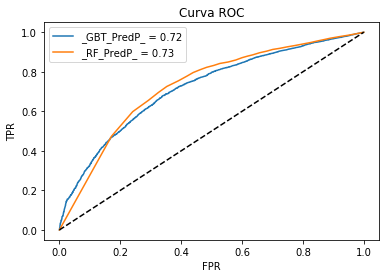

In [457]:
# Colunas de predicao de cada modelo
pred_columns = ["_GBT_PredP_", "_RF_PredP_"]

# Cria curvas ROC
my_roc = [ roc_curve( y_true=pd_castable["TARGET_x"] , y_score=pd_castable[i]) for i in pred_columns ]

# Calcula area sob a curva
my_roc_score = [roc_auc_score( y_true=pd_castable["TARGET_x"] , y_score=pd_castable[i]) for i in pred_columns ]

# Cria legenda e gráfico
legend = []
for i in range(2):
    legend.append(pred_columns[i]+ ' = ' + str(1-round(my_roc_score[i],2)))

for i in my_roc:
    plt.plot(i[1], i[0])
plt.plot([0,1],[0,1],'--k')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend(legend)
plt.title("Curva ROC")
plt.show()

In [443]:
conn.terminate()